<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

**Objective:** Emulate the Hugh Morrison Microphysics implemented in BAM1D


## Setup

First, we'll load the data.

In [40]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# working local
#
# original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
# original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")

# loading manually at each run
#
# import io
# from google.colab import files
# uploaded = files.upload()
# original_input_df = pd.read_csv(io.StringIO(uploaded['hug_morr_inputs.csv'].decode('utf-8')), sep=",")
# original_output_df = pd.read_csv(io.StringIO(uploaded['hug_morr_outputs.csv'].decode('utf-8')), sep=",")

# loading from gdrive
#
from google.colab import drive
drive.mount('/content/drive')
original_input_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_inputs.csv", sep=",")
original_output_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/hug_morr_outputs.csv", sep=",")

# generate random lines
input_df = original_input_df.reindex(np.random.permutation(original_input_df.index))
output_df = original_output_df.reindex(np.random.permutation(original_output_df.index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Summary of variables
Here we show a summary of values of input and output variables

Note that values are truncated in Summary

Histograms are shown ...

...also are exhibited the vertical levels of first, 100th and last timestep

In [41]:
print("\nInput First timestep:")
display.display(original_input_df.head(28))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[2800:2800+27])
print("\nInput Last timestep:")

display.display(original_input_df.tail(28))
print("\nAll input summary:")
display.display(original_input_df.describe())

print("\nOutput First timestep:")
display.display(original_output_df.head(28))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[2800:2800+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(28))
print("\nAll output summary:")
display.display(original_output_df.describe())





Input First timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
0,1,1.0,0.0,1.0,294.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,99000.0,-0.0
1,2,1.0,0.0,1.0,294.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,99000.0,-0.0
2,3,1.0,0.0,1.0,293.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
3,4,1.0,0.0,0.9,293.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
4,5,0.9,0.0,0.9,292.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,0.0,0.0,0.0,206.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
24,25,0.0,0.0,0.0,211.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
25,26,0.0,0.0,0.0,214.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
26,27,0.0,0.0,0.0,215.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0



Input 100th timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
2800,1,1.0,0.0,1.0,298.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,0.0,0.0,0.0,5.9,99000.0,0.0
2801,2,1.0,0.0,1.0,297.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.2,0.0,0.0,0.1,14.2,99000.0,0.0
2802,3,1.0,0.0,1.0,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.8,0.0,0.0,0.2,9.6,99000.0,0.0
2803,4,1.0,0.0,0.9,294.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.3,0.0,0.0,0.0,5.7,99000.0,0.0
2804,5,0.9,0.0,0.9,292.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,276.5,0.0,0.0,0.0,0.9,99000.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,0.0,0.0,0.0,206.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
2824,25,0.0,0.0,0.0,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
2825,26,0.0,0.0,0.0,203.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
2826,27,0.0,0.0,0.0,204.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,0.0



Input Last timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
265440,1,1.0,0.0,1.0,304.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.2,99000.0,-0.0
265441,2,1.0,0.0,1.0,303.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6,99000.0,0.0
265442,3,1.0,0.0,1.0,302.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,30.1,99000.0,0.0
265443,4,1.0,0.0,0.9,300.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,99000.0,0.0
265444,5,0.9,0.0,0.9,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,0.0,0.0,0.0,186.6,0.0,0.0,0.0,0.0,0.0,0.0,58817.6,3345402.3,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
265464,25,0.0,0.0,0.0,166.8,0.0,0.0,0.0,0.0,0.0,0.0,1334619.5,9456286.9,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
265465,26,0.0,0.0,0.0,138.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15370294.4,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
265466,27,0.0,0.0,0.0,114.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,99000.0,0.0



All input summary:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
count,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0
mean,14.5,0.5,0.0,0.5,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61165.5,1043501.1,4576.1,0.0,121900.3,0.3,28.6,99000.0,-0.0
std,8.1,0.4,0.0,0.4,57.6,0.0,0.0,0.0,0.0,0.0,0.0,278606.7,3399577.6,51098.1,0.1,980184.9,1.1,78.9,0.0,0.1
min,1.0,0.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99000.0,-1.0
25%,7.8,0.1,0.0,0.1,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,99000.0,-0.0
50%,14.5,0.4,0.0,0.4,260.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
75%,21.2,0.8,0.0,0.8,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42529.6,0.0,0.0,0.0,0.0,0.1,99000.0,0.0
max,28.0,1.0,0.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1740941.7,21.0,22999125.0,6.0,300.0,99000.0,0.2



Output First timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
0,1,294.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6677692.2,20.3,25.0,0.0,0.0
1,2,294.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6762603.6,13.7,25.0,0.0,0.0
2,3,293.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
3,4,293.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
4,5,292.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,206.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
24,25,211.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
25,26,214.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
26,27,215.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0



Output 100th timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
2800,1,298.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,25.0,25.0,0.0,0.0
2801,2,297.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.6,0.0,0.0,25.0,25.0,0.0,0.0
2802,3,296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.5,0.0,0.0,25.0,25.0,0.0,0.0
2803,4,294.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.8,0.0,0.0,25.0,25.0,0.0,0.0
2804,5,292.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381.1,0.0,0.0,25.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,206.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
2824,25,211.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
2825,26,203.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
2826,27,204.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0



Output Last timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
265440,1,304.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
265441,2,303.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
265442,3,302.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
265443,4,300.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
265444,5,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,186.6,0.0,0.0,0.0,0.0,0.0,0.0,58843.5,3344665.3,0.0,0.0,0.0,25.0,36.2,0.0,0.0
265464,25,166.8,0.0,0.0,0.0,0.0,0.0,0.0,1344231.3,9457125.7,0.0,0.0,0.0,25.0,24.3,0.0,0.0
265465,26,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15350885.7,0.0,0.0,0.0,25.0,25.0,0.0,0.0
265466,27,114.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0



All output summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0,265468.0
mean,14.5,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61176.0,1043612.4,4576.1,0.0,121900.3,24.6,28.4,0.0,0.0
std,8.1,57.6,0.0,0.0,0.0,0.0,0.0,0.0,278629.6,3399730.1,51098.1,0.1,980184.9,2.5,14.6,0.0,0.0
min,1.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,7.8,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,14.5,260.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,21.2,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42531.5,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,28.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1740941.7,21.0,22999125.0,27.6,130.0,0.0,0.0


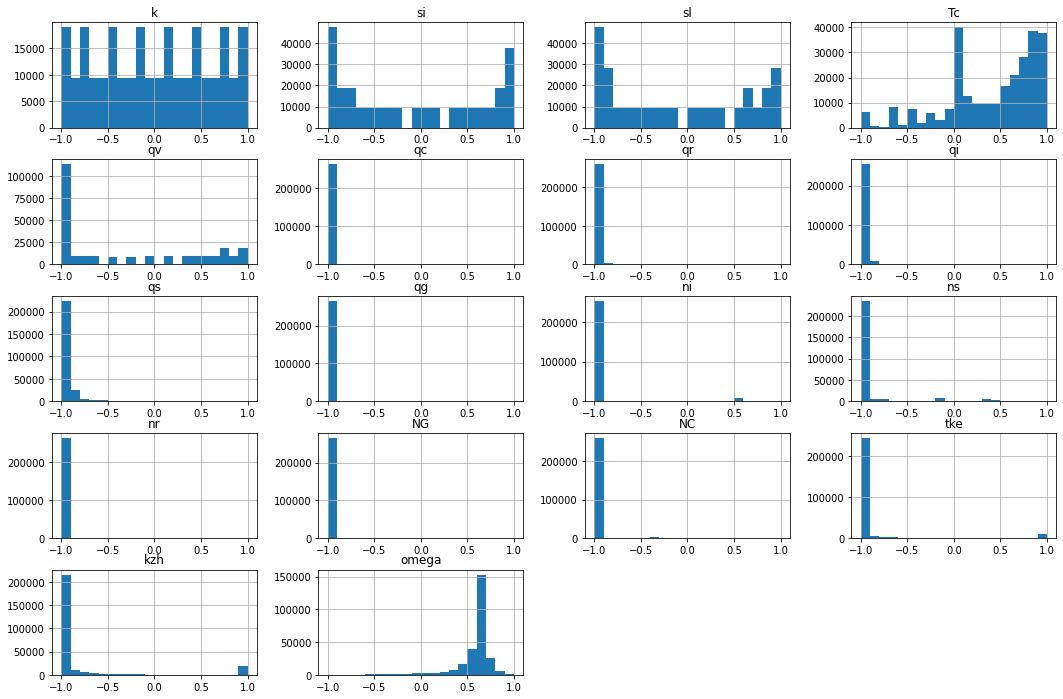

In [42]:
# Input Histograms

_ = all_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

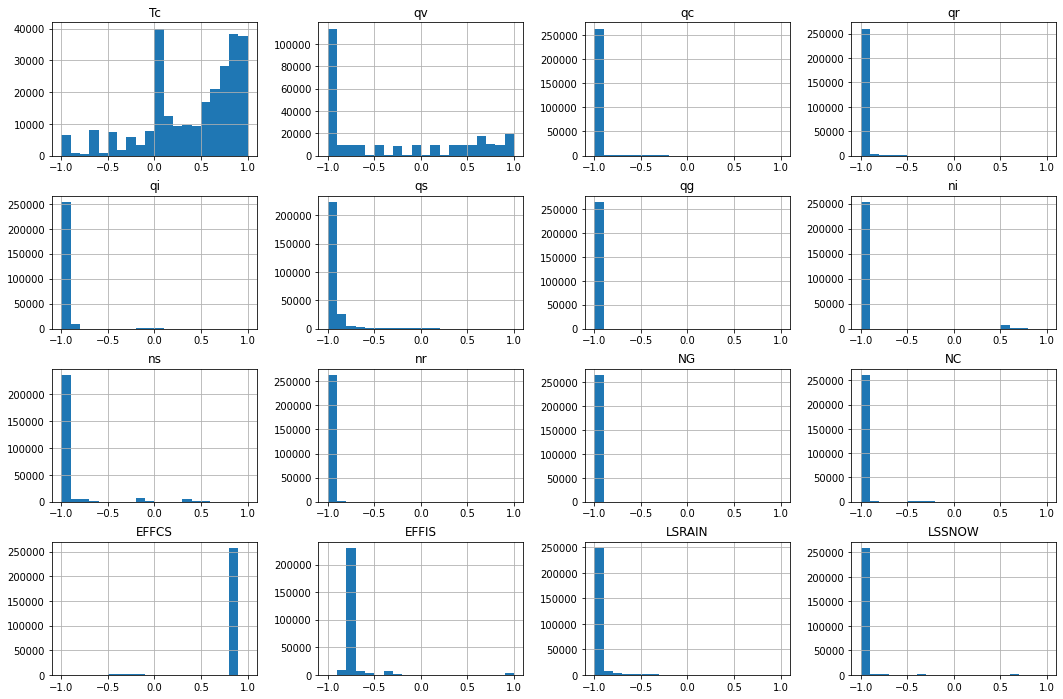

In [43]:
# Output Histograms

_ = all_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

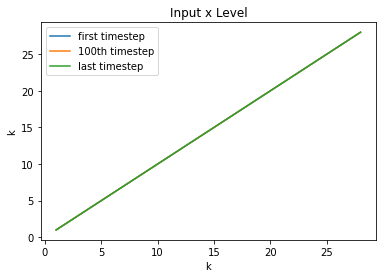

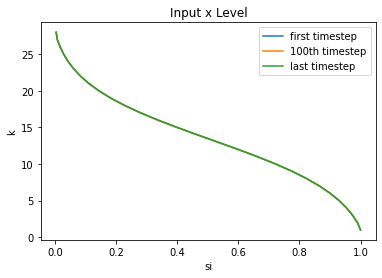

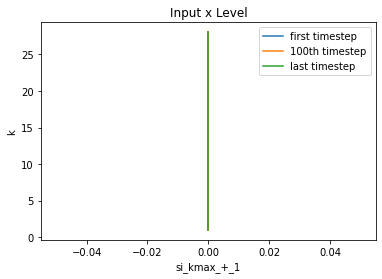

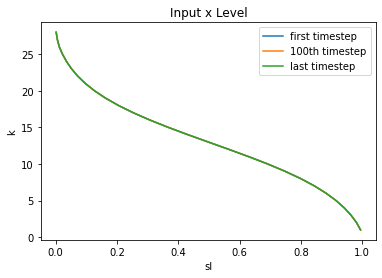

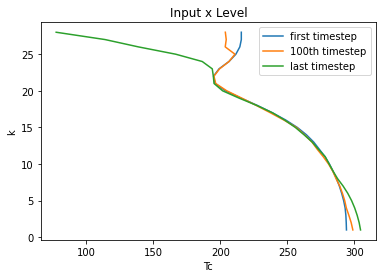

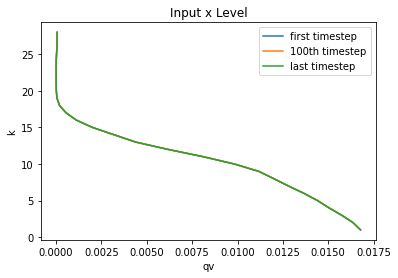

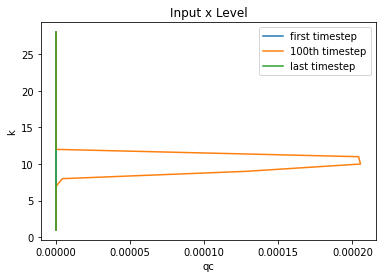

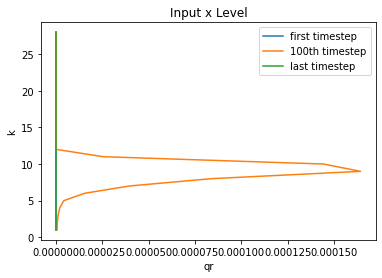

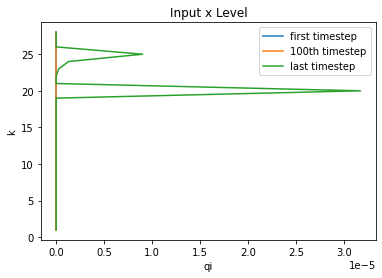

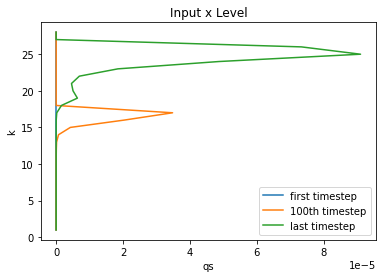

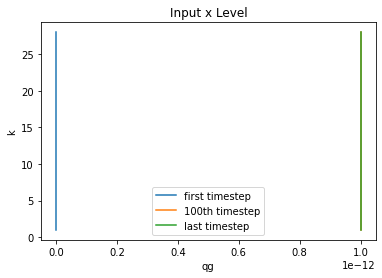

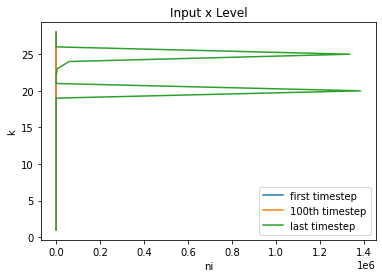

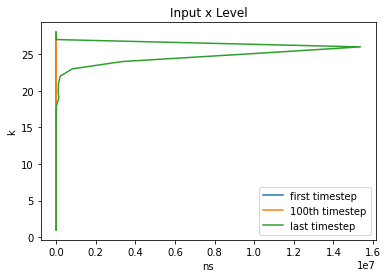

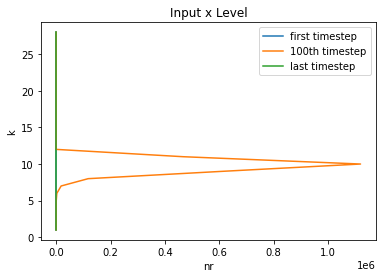

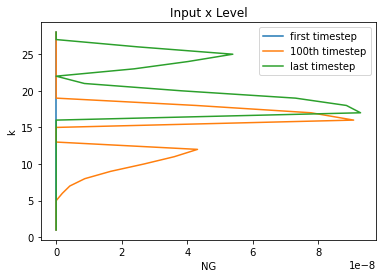

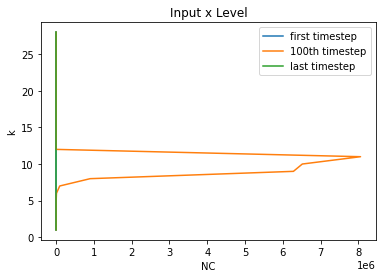

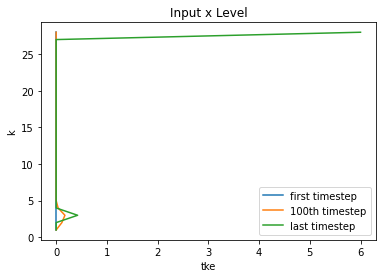

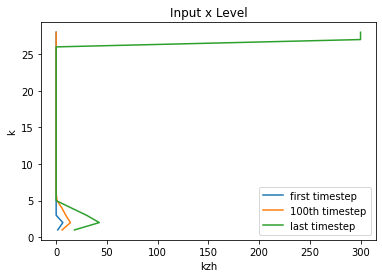

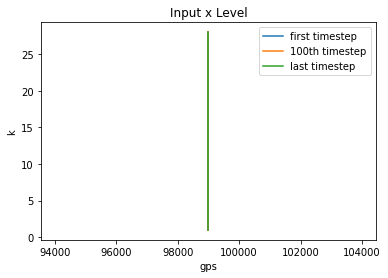

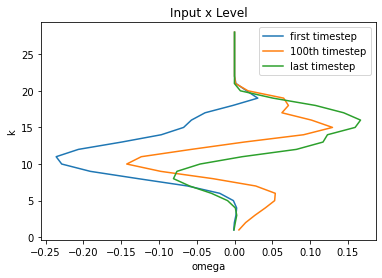

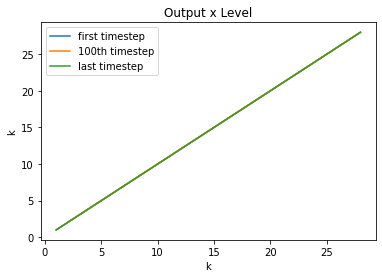

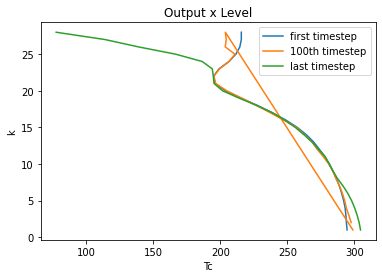

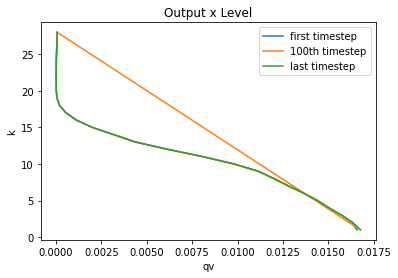

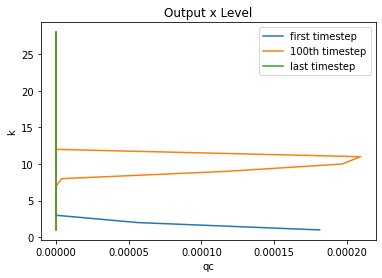

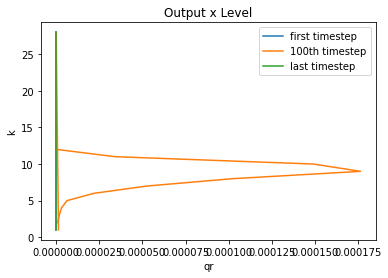

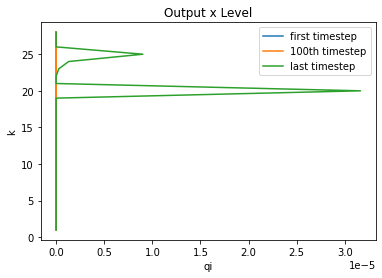

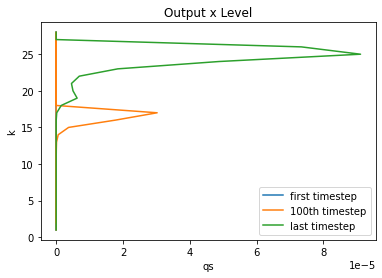

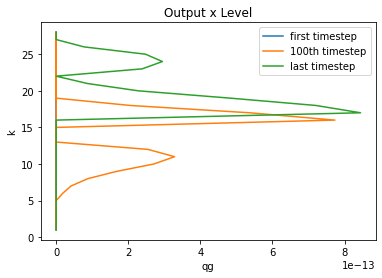

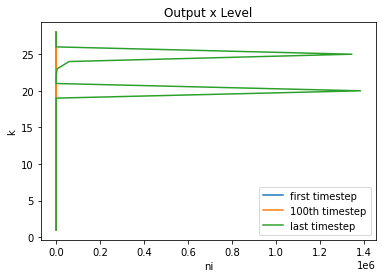

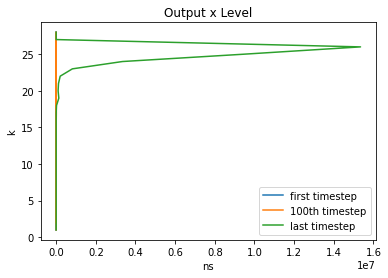

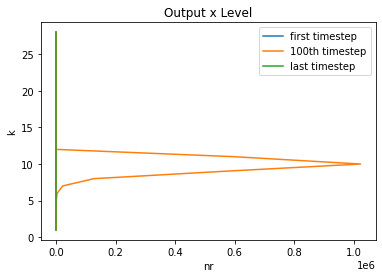

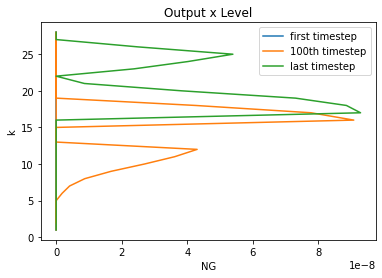

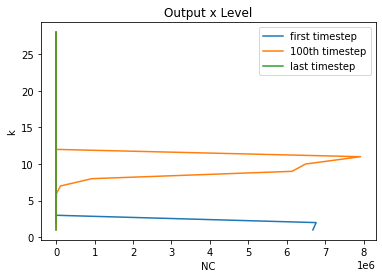

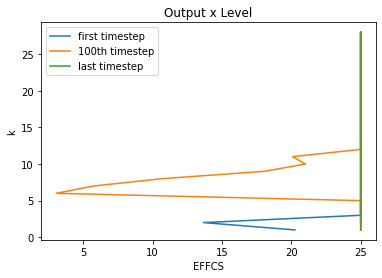

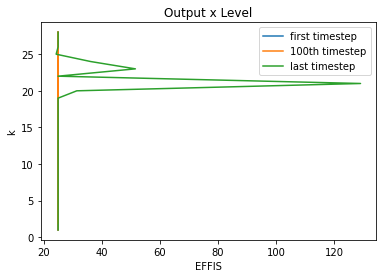

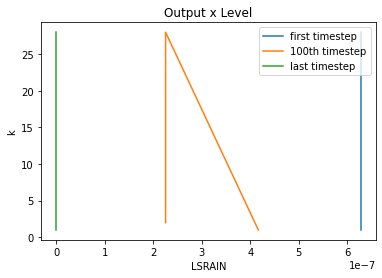

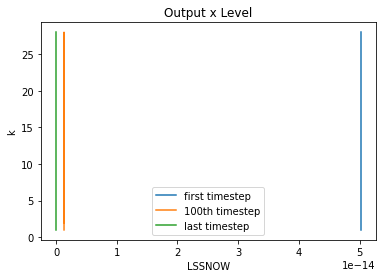

In [44]:
# Plot the vertical levels of first, 100th and last timestep

first_timestep_input_df = original_input_df.head(28)
med_timestep_input_df = original_input_df.loc[2800:2800+27]
last_timestep_input_df = original_input_df.tail(28)

for key in last_timestep_input_df.columns.tolist():
    plt.ylabel("k")
    plt.xlabel(key)
    plt.title("Input x Level")
    plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
    plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
    plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
    plt.legend()
    plt.show()

first_timestep_output_df = original_output_df.head(28)
med_timestep_output_df = original_output_df.loc[2801:2801+27]
last_timestep_output_df = original_output_df.tail(28)

for key in last_timestep_output_df.columns.tolist():
    plt.ylabel("k")
    plt.xlabel(key)
    plt.title("Output x Level")
    plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
    plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
    plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
    plt.legend()
    plt.show()

## Preprocessing the input (examples) and outputs (targets)
Here we select the input and output variables will be used in training and validation;
also we could create new variables as a composite of variables


In [45]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs",
    "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
#   processed_features["rooms_per_person"] = (
#     california_housing_dataframe["total_rooms"] /
#     california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data
      from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
#   # Scale the target to be in units of thousands of dollars.
#   output_targets["median_house_value"] = (
#     output_df["median_house_value"] / 1000.0)
  return output_targets

# execute the pre processing

all_examples = preprocess_features(input_df)
all_targets = preprocess_targets(output_df)


## Training and Validation Sets 
Here we select best variables
shows the summary of input and output of training and validaton sets, for checking the homogeneity of this sets
show th vertical profile of input and output variables, of first, 100th and last timestep

In [46]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

# Choose the first 185828 (70%) (out of 265469) for training.
training_examples = all_examples.head(185828)
training_targets = all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
validation_examples = all_examples.tail(79641)
validation_targets = all_targets.tail(79641)


print("Training examples summary:")
display.display(training_examples.describe())

print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())

print("Validation targets summary:")
display.display(validation_targets.describe())


Training examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,14.5,0.5,0.4,240.8,0.0,0.0,0.0,0.0,0.0,0.0,60977.5,1042042.6,4633.7,0.0,124732.6,0.3,28.5,-0.0
std,8.1,0.4,0.4,57.6,0.0,0.0,0.0,0.0,0.0,0.0,278169.5,3397520.9,51119.0,0.1,993638.5,1.1,78.6,0.1
min,1.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
25%,8.0,0.1,0.1,199.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,-0.0
50%,15.0,0.4,0.4,258.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.9,0.0,0.0,0.0,0.0,0.1,0.0
75%,22.0,0.8,0.8,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43184.4,0.0,0.0,0.0,0.0,0.1,0.0
max,28.0,1.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22604778.8,1631816.8,21.0,22999125.0,6.0,300.0,0.2


Validation examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,14.5,0.5,0.5,241.1,0.0,0.0,0.0,0.0,0.0,0.0,61603.4,1047085.6,4441.7,0.0,115290.1,0.3,29.0,-0.0
std,8.1,0.4,0.4,57.7,0.0,0.0,0.0,0.0,0.0,0.0,279623.8,3404753.6,51049.0,0.1,948018.1,1.2,79.4,0.1
min,1.0,0.0,0.0,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
25%,7.0,0.1,0.1,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,-0.0
50%,14.0,0.5,0.4,261.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,0.0,0.0,0.0,0.0,0.1,0.0
75%,21.0,0.9,0.8,290.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41602.8,0.0,0.0,0.0,0.0,0.1,0.0
max,28.0,1.0,1.0,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1743975.3,22283933.9,1740941.7,16.8,22994577.7,6.0,300.0,0.2


Training targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,240.9,0.0,0.0,0.0,0.0,0.0,0.0,61781.2,1044815.1,4497.4,0.0,121583.0,24.6,28.4,0.0,0.0
std,57.6,0.0,0.0,0.0,0.0,0.0,0.0,279953.5,3396215.1,50671.7,0.1,977859.3,2.5,14.6,0.0,0.0
min,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,199.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,259.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42720.8,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,310.3,0.0,0.0,0.0,0.0,0.0,0.0,1744027.0,22383072.8,1740941.7,16.8,22655093.6,25.0,130.0,0.0,0.0


Validation targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,240.9,0.0,0.0,0.0,0.0,0.0,0.0,59763.1,1040793.0,4760.2,0.0,122736.5,24.6,28.4,0.0,0.0
std,57.7,0.0,0.0,0.0,0.0,0.0,0.0,275510.5,3407918.1,52079.1,0.1,985959.2,2.5,14.7,0.0,0.0
min,76.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,-0.0,0.0
25%,199.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0
50%,260.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,25.0,25.0,0.0,0.0
75%,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42097.8,0.0,0.0,0.0,25.0,25.0,0.0,0.0
max,310.2,0.0,0.0,0.0,0.0,0.0,0.0,1743859.6,22604778.8,1503341.8,21.0,22999125.0,27.6,130.0,0.0,0.0


## Normalize the Features Using Linear Scaling

Normalize the inputs to the scale -1, 1.
As a rule of thumb, NN's train best when the input features are roughly on the same scale.

This helps NN not get stuck taking steps that are too large in one dimension, or too small in another.


In [47]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [48]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    # Convert pandas data into a dict of np arrays.
#   processed_features = pd.DataFrame()
  processed_features = examples_dataframe
  for key,value in dict(examples_dataframe).items():
    processed_features[key] = linear_scale(value)
  return processed_features
  

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

# Choose the first 185828 (70%) (out of 265469) for training.
normalized_training_examples = normalized_all_examples.head(185828)
normalized_training_targets = normalized_all_targets.head(185828)

# Choose the last 79641 (30%) (out of 265469) for validation.
normalized_validation_examples = normalized_all_examples.tail(79641)
normalized_validation_targets = normalized_all_targets.tail(79641)


print("Training examples summary:")
display.display(normalized_training_examples.describe())

print("Validation examples summary:")
display.display(normalized_validation_examples.describe())

print("Training targets summary:")
display.display(normalized_training_targets.describe())

print("Validation targets summary:")
display.display(normalized_validation_targets.describe())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Training examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,0.0,-0.1,-0.1,0.4,-0.3,-1.0,-1.0,-1.0,-1.0,-1.0,-0.9,-0.9,-1.0,-1.0,-1.0,-0.9,-0.8,0.6
std,0.6,0.7,0.7,0.5,0.8,0.1,0.1,0.1,0.1,0.0,0.3,0.3,0.1,0.0,0.1,0.4,0.5,0.2
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.5,-0.8,-0.9,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
50%,0.0,-0.2,-0.3,0.6,-0.8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
75%,0.6,0.6,0.6,0.8,0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
max,1.0,1.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,-0.0,-0.1,-0.1,0.4,-0.3,-1.0,-1.0,-1.0,-1.0,-1.0,-0.9,-0.9,-1.0,-1.0,-1.0,-0.9,-0.8,0.6
std,0.6,0.7,0.7,0.5,0.8,0.1,0.1,0.1,0.1,0.0,0.3,0.3,0.1,0.0,0.1,0.4,0.5,0.2
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.6,-0.8,-0.8,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
50%,-0.0,-0.1,-0.1,0.6,-0.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
75%,0.5,0.7,0.7,0.8,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.6
max,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.6,1.0,1.0,1.0,1.0


Training targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0,185828.0
mean,0.4,-0.3,-1.0,-1.0,-1.0,-1.0,-1.0,-0.9,-0.9,-1.0,-1.0,-1.0,0.8,-0.7,-1.0,-1.0
std,0.5,0.7,0.1,0.1,0.1,0.1,0.0,0.3,0.3,0.1,0.0,0.1,0.2,0.2,0.1,0.1
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
50%,0.6,-0.8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
75%,0.8,0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
max,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,1.0,0.8,1.0,1.0,1.0


Validation targets summary:


,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0,79641.0
mean,0.4,-0.3,-1.0,-1.0,-1.0,-1.0,-1.0,-0.9,-0.9,-1.0,-1.0,-1.0,0.8,-0.7,-1.0,-1.0
std,0.5,0.7,0.1,0.1,0.1,0.1,0.0,0.3,0.3,0.1,0.0,0.1,0.2,0.3,0.1,0.1
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
50%,0.6,-0.6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
75%,0.8,0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-0.8,-1.0,-1.0
max,1.0,1.0,1.0,0.6,1.0,1.0,0.7,1.0,1.0,0.7,1.0,1.0,1.0,1.0,1.0,1.0


## Train the Neural Network

Next, we'll train the neural network.

In [18]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [19]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [20]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

In [21]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

AttributeError: ignored